# Visualize Model Predictions

In [1]:
import json
import sys
import os
from pathlib import Path
import h5py

import numpy as np
import matplotlib.pyplot as plt
import torch

# Import model architecture.
CWD = os.path.join(Path().resolve())
sys.path.append(os.path.abspath(os.path.join(CWD, "..", "training")))
from models import build_model

In [2]:
# Specify job_id and hyperparamter config id.
config_id = "alex"
job_id = 6

# Path to model weights and config file.
job_dir = os.path.abspath(
    os.path.join(CWD, "../trained_models/{0:}/{1:05g}".format(config_id, job_id))
)

# Load config file.
with open(os.path.join(job_dir, "config.json")) as f:
    CONFIG = json.load(f)
print(CONFIG["MAX_LEARNING_RATE"])
print(CONFIG["OUTPUT_SCALE_FACTOR"])
print(CONFIG["INPUT_SCALE_FACTOR"])
# Load model.
model, _ = build_model(CONFIG)
# model.load_state_dict(torch.load(os.path.join(job_dir, "init_weights.pt")))
model.load_state_dict(torch.load(os.path.join(job_dir, "best_weights.pt")))
model.eval()

# Specify data file.
data_dir = os.path.abspath(os.path.join(CWD, "../data"))
data_file = h5py.File(os.path.join(data_dir, "train_set.h5"))

0.1
1.0
1.0


In [3]:
# Plot example vocalization
plt.plot(X[np.random.randint(20)].T)

NameError: name 'X' is not defined

In [ ]:
X = data_file["vocalizations"][:100]

In [ ]:
X.shape

In [ ]:
plt.plot(X[0].T)

In [4]:
np.max(X, axis=(0, -1))

NameError: name 'X' is not defined

In [5]:
np.argmax(X[2, -1, :])

NameError: name 'X' is not defined

In [6]:
X[:, 4:, :] *= 10

NameError: name 'X' is not defined

In [7]:
x = torch.from_numpy(X[np.random.randint(20)][0][18000:20000])
xp2 = torch.nn.functional.max_pool1d(x[None, :], kernel_size=2, stride=2)[0]
xp4 = torch.nn.functional.max_pool1d(xp2[None, :], kernel_size=2, stride=2)[0]
xp8 = torch.nn.functional.max_pool1d(xp4[None, :], kernel_size=2, stride=2)[0]
xp16 = torch.nn.functional.max_pool1d(xp8[None, :], kernel_size=2, stride=2)[0]
xp32 = torch.nn.functional.max_pool1d(xp16[None, :], kernel_size=2, stride=2)[0]
xp64 = torch.nn.functional.max_pool1d(xp32[None, :], kernel_size=2, stride=2)[0]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(np.arange(2000), x, ".-k", alpha=0.5, lw=2)
ax.plot(np.arange(2000)[::2], xp2, ".-b", lw=2)
ax.plot(np.arange(2000)[::4], xp4, ".-r", lw=2)
ax.plot(np.arange(2000)[::64][:-1], xp64, ".-g", lw=2)
# ax.set_xlim([200, 300])

NameError: name 'X' is not defined

(200.0, 600.0)

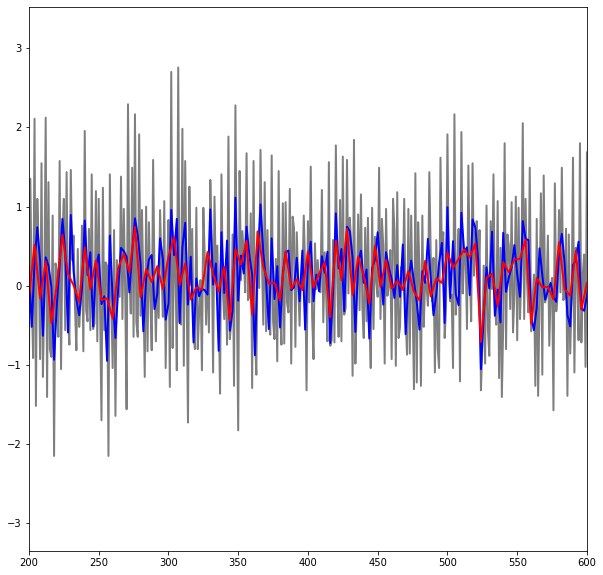

In [8]:
x = torch.from_numpy(data_file["vocalizations"][np.random.randint(100)][1][19000:20000])
xp = torch.nn.functional.avg_pool1d(x[None, :], kernel_size=2, stride=2)[0]
xp2 = torch.nn.functional.avg_pool1d(xp[None, :], kernel_size=2, stride=2)[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(np.arange(1000), x, "-k", alpha=0.5, lw=2)
ax.plot(np.arange(1000)[::2], xp, "-b", lw=2)
ax.plot(np.arange(1000)[::4], xp2, "-r", lw=2)
ax.set_xlim([200, 600])

In [45]:
10000 // 32

312

In [11]:
def compute_model_prediction(idx):
    audio_inputs = torch.from_numpy(
        data_file["vocalizations"][idx][None, :, 15000:25000]
    )
    with torch.no_grad():
        pred = model(audio_inputs).numpy()[0]
        return pred


def plot_model_prediction(idx):
    targ = data_file["locations"][idx] * 1e3
    x, y = targ[:, 0], targ[:, 1]
    pred = compute_model_prediction(idx) * 1e3
    xhat, yhat = pred[:, 0], pred[:, 1]
    for c, color in enumerate(("r", "b", "g")):
        plt.scatter(x[c], y[c], edgecolors=color, facecolors="none", s=100)
        plt.scatter(xhat[c], yhat[c], color=color, marker="+")

    plt.xlim([-300, 300])
    plt.ylim([-300, 300])
    plt.title(idx)

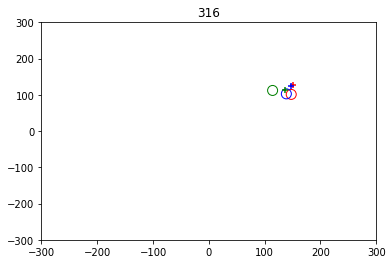

In [42]:
plot_model_prediction(np.random.randint(500))

In [18]:
from scipy.spatial.distance import pdist

meanlocs = np.array(data_file["locations"])
maxdists = []
for i, M in enumerate(meanlocs):
    maxdists.append(pdist(M).max())
sorted_idx = np.argsort(maxdists)[::-1]

In [ ]:
def compute_model_prediction(idx):
    audio_inputs = torch.from_numpy(data_file["vocalizations"][idx][None, :, :])
    with torch.no_grad():
        pred = model(audio_inputs).numpy()[0]
        return pred